# [Heisenberg Model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model)

$$
H = -\frac{1}{2}\sum^N_{i=1}(J_x X_i X_{i+1} + J_y Y_i Y_{i+1} + J_z Z_i Z_{i+1} + h Z_i)
$$
$h$ indicates the magnetic field

In [36]:
import pennylane as qml
import matplotlib.pyplot as plt
import pennylane.numpy as np
import scipy

In [7]:
def Heisenberg(size: int, jx: float, jy: float, jz: float, h:float, pbc: bool = False) -> qml.Hamiltonian:
    """
    Heisenberg Model

    Args:
        size (int): size of the lattice
        jx (float): J_x term coefficient
        jy (float): J_y term coefficient
        jz (float): J_z term coefficient
        h (float): Magnetic field strength
        pbc (bool, optional): periodic boundary conditions. Defaults to False.

    Returns:
        qml.Hamiltonian: 
            Heisenberg Hamiltonian
    """
    assert size > 2, "Invalid size"
    coefs = [-h] * size
    terms = [qml.PauliZ(idx) for idx in range(size)]
    for idx in range(size-1):
        coefs.append(-jx)
        terms.append(qml.PauliX(idx) @ qml.PauliX(idx+1))
        
        coefs.append(-jy)
        terms.append(qml.PauliY(idx) @ qml.PauliY(idx+1))
        
        coefs.append(-jz)
        terms.append(qml.PauliZ(idx) @ qml.PauliZ(idx+1))
        
    if pbc:
        coefs.append(-jx)
        terms.append(qml.PauliX(size-1) @ qml.PauliX(0))
        
        coefs.append(-jy)
        terms.append(qml.PauliY(size-1) @ qml.PauliY(0))
        
        coefs.append(-jz)
        terms.append(qml.PauliZ(size-1) @ qml.PauliZ(0))

    return qml.Hamiltonian(coefs, terms)

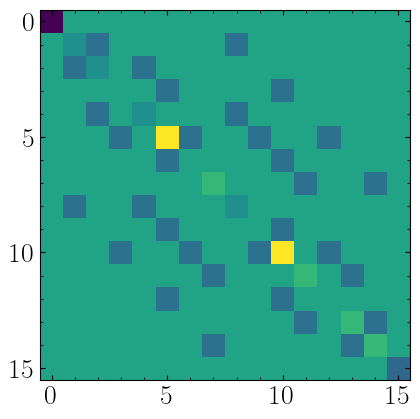

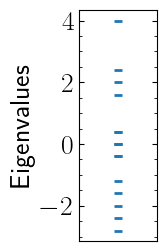

Ground state energy: -2.800
Excited state energy: -2.400


In [11]:
model = Heisenberg(4, 0.5, 0.5,0.5, 0.2, pbc=True)
plt.imshow(qml.matrix(model).real)
plt.show()

e, v = np.linalg.eigh(qml.matrix(model))
fig = plt.figure(figsize=(1, 3))
plt.scatter([0] * len(e), e, marker="_")
plt.xticks([])
plt.ylabel("Eigenvalues")
plt.show()

print(f"Ground state energy: {min(e):.3f}")
print(f"Excited state energy: {e[1]:.3f}")

In [71]:
NLAYERS = 3
shapes = qml.SimplifiedTwoDesign.shape(NLAYERS, 4)
shapes

[(4,), (3, 3, 2)]

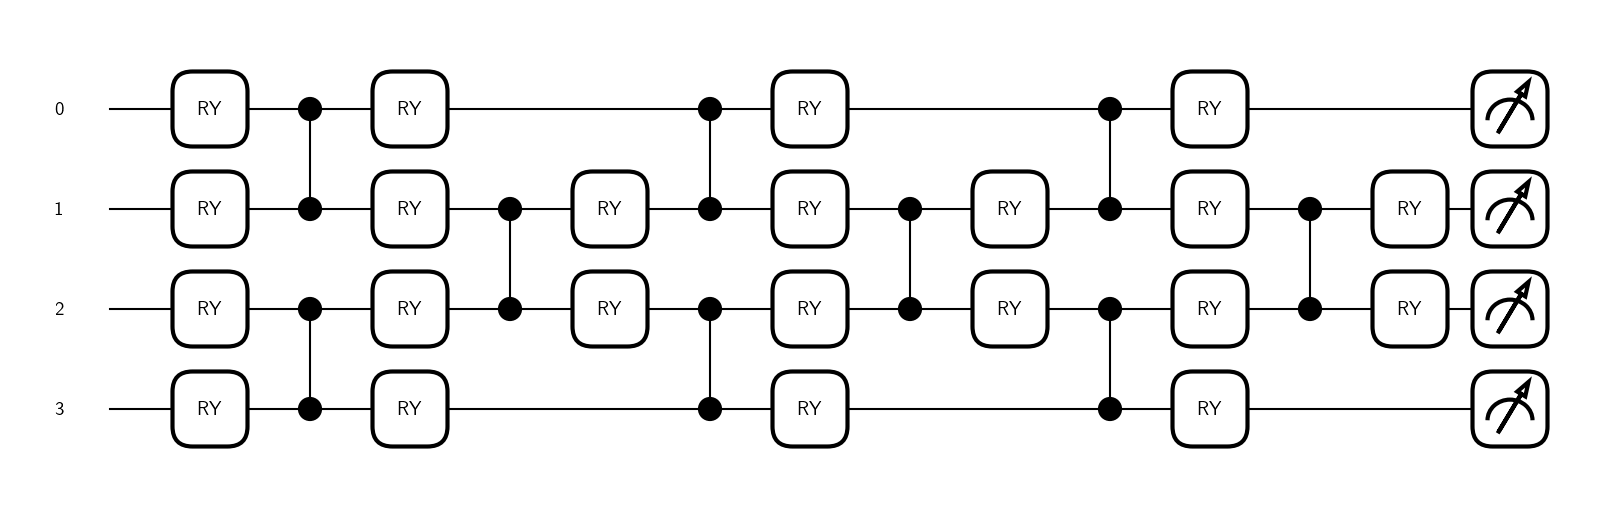

In [72]:
@qml.qnode(qml.device("default.qubit", wires=4))
def circuit(par1, par2):
    qml.SimplifiedTwoDesign(par1, par2, wires=range(4))
    return qml.expval(op=model)


qml.draw_mpl(circuit, expansion_strategy="device")(
    np.random.random(shapes[0]), np.random.random(shapes[1])
)
plt.show()

In [73]:
gradient = qml.grad(circuit, argnum=[0, 1])


loss = []


def cost(pars):
    initials = pars[: np.prod(shapes[0])]
    weights = pars[np.prod(shapes[0]) :].reshape(shapes[1])
    
    expval = circuit(initials, weights)
    grad = gradient(initials, weights)

    loss.append(expval)
    return expval, np.hstack([grad[0], grad[1].reshape(np.prod(shapes[1]))])


pars = np.random.random(np.prod(shapes[0]) + np.prod(shapes[1]))

opt = scipy.optimize.minimize(
    cost,
    pars,
    method="SLSQP",
    jac=True,
    hess=None,
    bounds=None,
    constraints=None,
    tol=1e-4,
    options={"maxiter": 10000, "disp": True},
)

print(f"\n\nreconstructed ground state energy: {opt.fun:.3f}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.799811149641157
            Iterations: 21
            Function evaluations: 24
            Gradient evaluations: 21


reconstructed ground state energy: -2.800


Text(0.5, 0, 'Epoch')

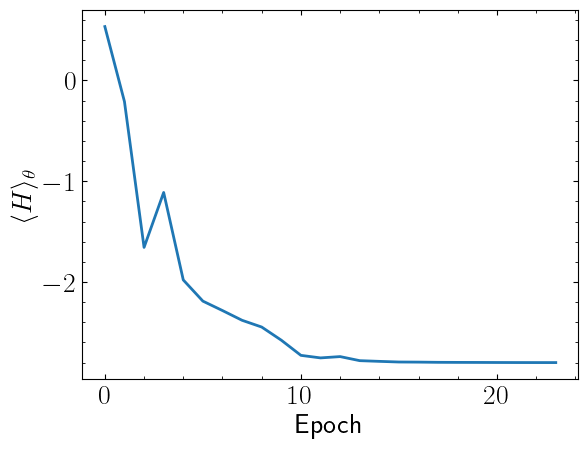

In [74]:
plt.plot(loss)
plt.ylabel(r"$\langle H \rangle_\theta$")
plt.xlabel("Epoch")

# Find the first excited state

$$ \mathcal{P}_0 = |\psi_0\rangle\langle\psi_0| \quad , \quad \langle\mathcal{H}^\prime\rangle = \langle\mathcal{H}\rangle + \alpha \langle \psi_1| \mathcal{P}_0 | \psi_1 \rangle = \langle\mathcal{H}\rangle + \alpha |\langle \psi_1| \psi_0 \rangle |^2 $$

In [75]:
@qml.qnode(qml.device("default.qubit", wires=4))
def circuit(par1, par2):
    qml.SimplifiedTwoDesign(par1, par2, wires=range(4))
    return qml.expval(op=model), qml.state()

In [76]:
initials = opt.x[: np.prod(shapes[0])]
weights = opt.x[np.prod(shapes[0]) :].reshape(shapes[1])
expval, ground_state = circuit(initials, weights)
print(f"Ground state energy: {expval:.3f}")

Ground state energy: -2.800


In [83]:
def new_cost(*parameters):
    expval, state = circuit(parameters[0], parameters[1])
    return expval + 5*np.sqrt(np.abs(state @ ground_state.conj().transpose()))

gradient = qml.grad(new_cost, argnum=[0, 1])

In [84]:
gradient(np.random.random(shapes[0]), np.random.random(shapes[1]))

(array([-1.3362839 , -0.59568472,  0.11110538, -2.01700492]),
 array([[[-1.38249862, -0.86134581],
         [ 0.05574468, -1.98562668],
         [-1.20731243, -0.36944057]],
 
        [[-0.92957201, -0.53634755],
         [-0.42763086, -0.61775791],
         [-0.07902933, -0.17255449]],
 
        [[-1.0754353 , -0.08528879],
         [-0.08842268, -1.12513157],
         [ 0.06618449, -0.60295603]]]))

In [85]:
loss = []

def cost(pars):
    initials = pars[: np.prod(shapes[0])]
    weights = pars[np.prod(shapes[0]) :].reshape(shapes[1])
    
    expval = new_cost(initials, weights)
    grad = gradient(initials, weights)

    loss.append(expval)
    return expval, np.hstack([grad[0], grad[1].reshape(np.prod(shapes[1]))])


pars = np.random.random(np.prod(shapes[0]) + np.prod(shapes[1]))

opt = scipy.optimize.minimize(
    cost,
    pars,
    method="SLSQP",
    jac=True,
    hess=None,
    bounds=None,
    constraints=None,
    tol=1e-4,
    options={"maxiter": 10000, "disp": True},
)

initials = opt.x[: np.prod(shapes[0])]
weights = opt.x[np.prod(shapes[0]) :].reshape(shapes[1])
expval, excited_state = circuit(initials, weights)

print(f"\n\nreconstructed ground state energy: {expval:.3f}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.220496110676222
            Iterations: 41
            Function evaluations: 182
            Gradient evaluations: 41


reconstructed ground state energy: -2.221


Text(0.5, 0, 'Epoch')

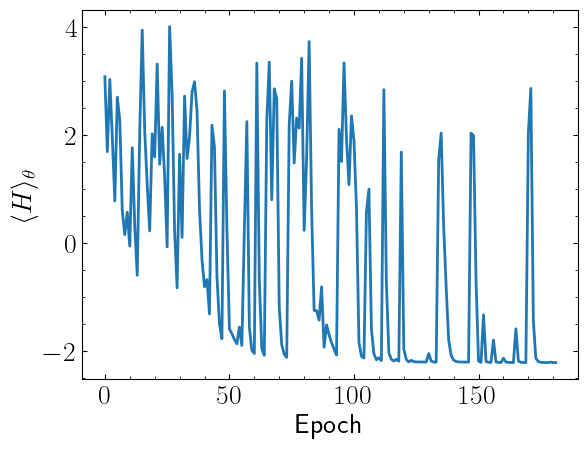

In [86]:
plt.plot(loss)
plt.ylabel(r"$\langle H \rangle_\theta$")
plt.xlabel("Epoch")

**Question**: How can we improve this result? 

- Increase $\alpha$?
- Increase number of layer?